## 厦门人才网招聘数据分析
本数据来源于厦门人才网，网址：https://www.xmrc.com.cn     
通过原创爬虫于2018-9-5至9-8爬取的厦门人才网一周内的招聘信息，爬虫代码已上传到GitHub,地址：https://github.com/MabelFan/crawl_web.git      

数据的变量总共有18项，名称介绍如下：   
1. 职位名称  
2. 公司名称  
3. 招聘日期  
4. 截止日期  
5. 招聘部门  
6. 联系人  
7. 通信地址  
8. 学历要求  
9. 性别要求  
10. 职位性质     
11. 招聘对象     
12. 工作地点   
13. 参考月薪   
14. 上班时间    
15. 上班天数   
16. 薪资福利    
17. 岗位职责    
18. 电子邮件    

### 导入库

In [1]:
# Import libraries
import os, re, jieba
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from PIL import Image
from scipy.misc import imread
from wordcloud import WordCloud, ImageColorGenerator
import folium
from folium.plugins import HeatMap
from pyecharts import Pie, Bar

%matplotlib inline

### 数据读取 

In [2]:
jobs_xmrc = pd.read_csv('/Users/mabelfan/Documents/Python/Git/some_projects/jobs_xmrc/jobs_xmrc_OneWeek.csv')

In [3]:
jobs_xmrc_clean = jobs_xmrc.copy()
jobs_xmrc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110567 entries, 0 to 110566
Data columns (total 18 columns):
职位名称    110567 non-null object
公司名称    110567 non-null object
招聘日期    110567 non-null object
截止日期    110567 non-null object
招聘部门    44466 non-null object
联系人     110566 non-null object
通信地址    110566 non-null object
学历要求    110567 non-null object
性别要求    110567 non-null object
职位性质    110567 non-null object
招聘对象    110567 non-null object
工作地点    110561 non-null object
参考月薪    85945 non-null object
上班时间    83395 non-null object
上班天数    0 non-null float64
薪资福利    86867 non-null object
岗位职责    53271 non-null object
电子邮件    34852 non-null object
dtypes: float64(1), object(17)
memory usage: 15.2+ MB


### 数据整理与清洗 

1.重复值   
以公司名称、职位名称、通信地址、工作地点和参考月薪为主要目标来确认是否为重复招聘岗位。   

In [4]:
print('爬取的原数据总数：',len(jobs_xmrc_clean))

爬取的原数据总数： 110567


In [5]:
sum(jobs_xmrc_clean.duplicated(['职位名称','公司名称','招聘部门','通信地址','招聘对象','工作地点','参考月薪']))

47731

In [6]:
print("一周内岗位重复率高达：{:.2f}".format((47731/110567)*100)+"%")

一周内岗位重复率高达：43.17%


In [7]:
jobs_xmrc_clean.drop_duplicates(['职位名称','公司名称','招聘部门','通信地址','招聘对象','工作地点','参考月薪'],inplace=True)
sum(jobs_xmrc_clean.duplicated(['职位名称','公司名称','招聘部门','通信地址','招聘对象','工作地点','参考月薪']))

0

In [8]:
print('删除重复值后的数据总数：',len(jobs_xmrc_clean))

删除重复值后的数据总数： 62836


2.空值、缺失值处理

In [9]:
cols_with_missing = [col for col in jobs_xmrc_clean.columns 
                                 if jobs_xmrc_clean[col].isnull().any()]
cols_with_missing

['招聘部门', '联系人', '通信地址', '工作地点', '参考月薪', '上班时间', '上班天数', '薪资福利', '岗位职责', '电子邮件']

In [10]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [11]:
draw_missing_data_table(jobs_xmrc_clean)

,Total,Percent
上班天数,62836,1.000000
电子邮件,43037,0.684910
招聘部门,37840,0.602203
岗位职责,33110,0.526927
上班时间,15859,0.252387
参考月薪,14601,0.232367
薪资福利,13901,0.221227
工作地点,4,0.000064
通信地址,1,0.000016
联系人,1,0.000016


针对前面3列的数据，考虑删除；   
对于参考月薪为空的行，直接删除;   
另岗位职责中有不少信息可提取，补充到其他信息缺少的行中,如上班时间、薪资福利、工作地点、通信地址和联系人。  

In [12]:
jobs_xmrc_clean.drop(['上班天数','电子邮件','招聘部门'],axis=1,inplace=True)

In [13]:
jobs_xmrc_clean.drop(jobs_xmrc_clean.loc[jobs_xmrc_clean['参考月薪'].isnull(),:].index,inplace=True)
print('删除参考月薪为空的数据总数：',len(jobs_xmrc_clean))

删除参考月薪为空的数据总数： 48235


In [14]:
jobs_xmrc_clean.reset_index(drop=True,inplace=True)

In [15]:
jobs_xmrc_clean.tail()

,职位名称,公司名称,招聘日期,截止日期,联系人,通信地址,学历要求,性别要求,职位性质,招聘对象,工作地点,参考月薪,上班时间,薪资福利,岗位职责
48230,陈列设计师（急招）,厦门乙顺商贸有限公司,2018-09-07,2018-10-07 14:23,张先生(人事行政部),厦门市思明区鹭江道96号钻石海岸B幢25楼(361002),大专以上,男,全职,不限,厦门市思明区,5000-8000元/月,8.0小时/天,五险、带薪年假、绩效奖金、加班补贴、住房补贴、餐饮补贴、节日福利、员工旅游、全勤奖,：1.负责品牌宣传活动物料的平面设计工作，包含海报、画册、POP、主题活动背板设计等；2.负...
48231,设计总监,厦门华亿传媒集团股份有限公司,2018-09-07,2018-09-17 14:23,柳小姐(人力资源部),厦门市思明区深田路46号深田国际大厦1203室(361009)(合则约见、非请勿访),大专以上,不限,全职,五年工作经验以上,厦门市、厦门市思明区,10000-11000元/月(底薪：7500-8500元/月+提成),7.0小时/天,五险、住房公积金、带薪年假、绩效奖金、高温补贴、节日福利、专业培训、定期体检,：1、负责公司主办或承办的展庆活动项目、品牌设计等相关平面工作，了解客户意图，将方案、文案、...
48232,设计副总监,厦门华亿传媒集团股份有限公司,2018-09-07,2018-09-17 14:23,柳小姐(人力资源部),厦门市思明区深田路46号深田国际大厦1203室(361009)(合则约见、非请勿访),大专以上,不限,全职,四年工作经验以上,厦门市、厦门市思明区,7500-10000元/月,7.0小时/天,五险、住房公积金、带薪年假、高温补贴、节日福利、专业培训、定期体检,：1、按时、高效完成项目的设计排版及提案方案设计制作，负责公司书刊、创意等相关平面工作；2、...
48233,装修工程预算,厦门华亿传媒集团股份有限公司,2018-09-07,2018-09-14 14:23,柳小姐(人力资源部),厦门市思明区深田路46号深田国际大厦1203室(361009)(合则约见、非请勿访),大专以上,不限,全职,不限,厦门市、厦门市思明区,4000-4500元/月,7.0小时/天,五险、住房公积金、商业保险、带薪年假、绩效奖金、高温补贴、节日福利、专业培训、定期体检,：负责工程项目的报价、跟进项目进展、负责工程项目成本管控工作、完工项目预算与结算费用分析对比...
48234,编辑,厦门华亿传媒集团股份有限公司,2018-09-07,2018-09-17 14:23,柳小姐(人力资源部),厦门市思明区深田路46号深田国际大厦1203室(361009)(合则约见、非请勿访),本科以上,不限,全职,不限,厦门市、厦门市思明区,2500-5000元/月,7.0小时/天,五险、住房公积金、带薪年假、绩效奖金、高温补贴、节日福利、专业培训、定期体检,：1、负责执行出版业务采访编辑、设计校对、印刷发行、印刷监督等流程；2、负责整理编辑书籍、期...


In [16]:
# 从参考月薪开始
salaryRegex1 = re.compile(r'(\d*)\s*-\s*(\d*)')

jobs_xmrc_clean['salary_L']=pd.Series()
jobs_xmrc_clean['salary_U']=pd.Series()
jobs_xmrc_clean['salary_A']=pd.Series()


for i in jobs_xmrc_clean['参考月薪'].index:
    jobs_xmrc_clean.loc[i,'salary_L'] =  salaryRegex1.search(jobs_xmrc_clean.loc[i,'参考月薪']).group(1)
    jobs_xmrc_clean.loc[i,'salary_U'] =  salaryRegex1.search(jobs_xmrc_clean.loc[i,'参考月薪']).group(2)

In [17]:
jobs_xmrc_clean['salary_L'] = jobs_xmrc_clean['salary_L'].astype('int64')

In [18]:
def conv_type(data,col1,col2):
    for i in data[col1].index:
        try:
            data.loc[i,col1] = int(data.loc[i,col1])
        except:
            data.loc[i,col1] = data.loc[i,col2]

In [19]:
conv_type(jobs_xmrc_clean,'salary_U','salary_L')

In [20]:
jobs_xmrc_clean['salary_A']= (jobs_xmrc_clean['salary_L'] + jobs_xmrc_clean['salary_U'])/2
jobs_xmrc_clean['salary_A'] = jobs_xmrc_clean['salary_A'].astype('int64')

In [21]:
def get_more(var,patt):
    for row in jobs_xmrc_clean.loc[jobs_xmrc_clean[var].isnull(),:].index:
        value = salary_patt.findall(str(jobs_xmrc_clean.loc[row,'岗位职责']))
        if len(value) > 0:
            jobs_xmrc_clean.loc[row,var] = value[0]
        else:
            jobs_xmrc_clean.loc[row,var] = None

In [22]:
def fill_location(data,col1,col2):
    for i in jobs_xmrc_clean[jobs_xmrc_clean[col1].isnull()].index:
        jobs_xmrc_clean.loc[i,col1] = jobs_xmrc_clean.loc[i,col2].strip()

fill_location(jobs_xmrc_clean,'工作地点','通信地址')

In [23]:
fill_location(jobs_xmrc_clean,'通信地址','工作地点')

In [24]:
# 找出非厦门工作地点的数据
non_amoy = []
for i in jobs_xmrc_clean.index:
    if jobs_xmrc_clean.loc[i,'通信地址'].find('厦门') == -1 and jobs_xmrc_clean.loc[i,'工作地点'].find('厦门') == -1:
        non_amoy.append(i)
len(non_amoy)

1845

In [25]:
#删除公司或工作地点不在厦门的岗位
jobs_xmrc_clean.drop(non_amoy,inplace=True)

In [26]:
len(jobs_xmrc_clean)

46390

### 数据分析

问题思考：   
1. 厦门招聘岗位的薪资待遇分布情况    
2. 厦门不同城区的招聘岗位需求情况和薪资差异   

#### 1. 薪资待遇分布情况 

In [27]:
jobs_xmrc_clean.describe()

,salary_L,salary_U,salary_A
count,46390.000000,46390.000000,46390.000000
mean,5077.025243,8140.641259,6608.832615
std,3017.103067,5221.500230,4062.170340
min,1.000000,1.000000,1.000000
25%,3500.000000,5000.000000,4250.000000
50%,4000.000000,7000.000000,5500.000000
75%,6000.000000,10000.000000,7500.000000
max,100000.000000,100000.000000,100000.000000


In [28]:
def salary_upper(salary):
    jobs_xmrc_upper = jobs_xmrc_clean[jobs_xmrc_clean['salary_A']>= int(salary)]
    print('薪资超过'+salary+'的岗位数：',len(jobs_xmrc_upper),'\n',\
          '占总招聘数量的比例是：','%.1f'%(float(len(jobs_xmrc_upper)/len(jobs_xmrc_clean))*100) +'%')
    return jobs_xmrc_upper

In [29]:
jobs_xmrc_20k = salary_upper('20000')

薪资超过20000的岗位数： 665 
 占总招聘数量的比例是： 1.4%


In [30]:
jobs_xmrc_40k = salary_upper('40000')

薪资超过40000的岗位数： 65 
 占总招聘数量的比例是： 0.1%


In [31]:
jobs_xmrc_60k = salary_upper('60000')

薪资超过60000的岗位数： 23 
 占总招聘数量的比例是： 0.0%


In [32]:
jobs_xmrc_80k = salary_upper('80000')

薪资超过80000的岗位数： 6 
 占总招聘数量的比例是： 0.0%


In [33]:
jobs_xmrc_100k = salary_upper('100000')
jobs_xmrc_100k

薪资超过100000的岗位数： 1 
 占总招聘数量的比例是： 0.0%


,职位名称,公司名称,招聘日期,截止日期,联系人,通信地址,学历要求,性别要求,职位性质,招聘对象,工作地点,参考月薪,上班时间,薪资福利,岗位职责,salary_L,salary_U,salary_A
4564,总经理,厦门维尔斯人力资源管理有限公司,2018-09-06,2018-10-06 10:39,Mike(顾问师),厦门市思明区吕岭路1819号精图大厦（软件园二期东二门精图信息大厦）B304-307（软件园...,本科以上,男,全职,十五年工作经验以上,厦门市,100000-100000元/月,8.0小时/天,五险、住房公积金,：1、品牌推广、品牌影响力做大；2、业绩、营业额做强。任职资格：1、35-50之间，大健康背...,100000,100000,100000


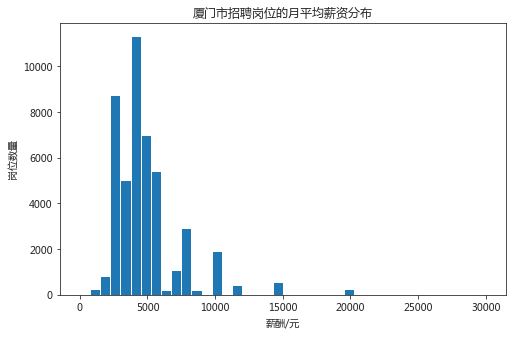

In [34]:
sns.set_style('ticks')
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] 

def hist_salary(data):
    fig,ax = plt.subplots(1,1,figsize=(8,5))

    ax.hist(data['salary_L'],bins=40,stacked=True)
    props={
        'title':'厦门市招聘岗位的月平均薪资分布',
        'ylabel':'岗位数量',
        'xlabel':'薪酬/元'
    }
    ax.set(**props)
    fig.savefig('厦门市招聘岗位的月平均薪资分布.png')
    plt.show()

jobs_xmrc_40kLower = jobs_xmrc_clean[jobs_xmrc_clean['salary_A'] < 40000]
hist_salary(jobs_xmrc_40kLower)

In [35]:
#对薪资按范围了解各水平比例情况
salary_dict = {'3K以下':1,'3K-5K':2,'5K-7K':3,'7K-10K':4,'10K-15K':5,'15k-20k':6,'20K-30K':7,'30k以上':8}

jobs_xmrc_clean['salary_cls'] = 0

In [36]:
def salary_step():
    for i in jobs_xmrc_clean['salary_A'].index:
        if jobs_xmrc_clean.loc[i,'salary_A'] <= 3000:
            jobs_xmrc_clean.loc[i,'salary_cls'] = 1
        elif jobs_xmrc_clean.loc[i,'salary_A'] <= 5000:
            jobs_xmrc_clean.loc[i,'salary_cls'] = 2
        elif jobs_xmrc_clean.loc[i,'salary_A'] <= 7000:
            jobs_xmrc_clean.loc[i,'salary_cls'] = 3
        elif jobs_xmrc_clean.loc[i,'salary_A'] <= 10000:
            jobs_xmrc_clean.loc[i,'salary_cls'] = 4
        elif jobs_xmrc_clean.loc[i,'salary_A'] <= 15000:
            jobs_xmrc_clean.loc[i,'salary_cls'] = 5
        elif jobs_xmrc_clean.loc[i,'salary_A'] <= 20000:
            jobs_xmrc_clean.loc[i,'salary_cls'] = 6
        elif jobs_xmrc_clean.loc[i,'salary_A'] <= 30000:
            jobs_xmrc_clean.loc[i,'salary_cls'] = 7
        elif jobs_xmrc_clean.loc[i,'salary_A'] > 30000:
            jobs_xmrc_clean.loc[i,'salary_cls'] = 8

salary_step()

In [37]:
jobs_xmrc_clean_salaryR = jobs_xmrc_clean.groupby('salary_cls',as_index=False).count()
jobs_xmrc_clean_salaryR = jobs_xmrc_clean_salaryR[['salary_cls','职位名称']]

In [38]:
def barticks(num):
    prop = jobs_xmrc_clean_salaryR.loc[num-1,'职位名称']/jobs_xmrc_clean_salaryR['职位名称'].sum()*100
    ax.text(num-0.3,prop+.5,'%.1f'%prop + '%')

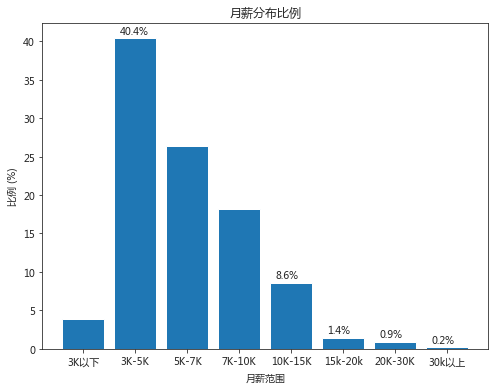

In [39]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.bar(x=jobs_xmrc_clean_salaryR['salary_cls'],tick_label=list(salary_dict.keys()),\
        height=jobs_xmrc_clean_salaryR['职位名称']/jobs_xmrc_clean_salaryR['职位名称'].sum()*100)

ax.set(title='月薪分布比例',xlabel='月薪范围',ylabel='比例 (%)')
barticks(2)
barticks(5)
barticks(6)
barticks(7)
barticks(8)

fig.savefig('月薪分布比例.png')


#### 2. 厦门不同城区的招聘岗位需求情况和薪资差异 

In [40]:
#通信地址为空值的处理
for i in jobs_xmrc_clean[jobs_xmrc_clean['通信地址'].isnull()].index:
    jobs_xmrc_clean.loc[i,'通信地址'] = jobs_xmrc_clean.loc[i,'工作地点']
len(jobs_xmrc_clean[jobs_xmrc_clean['通信地址'].isnull()])

0

In [41]:
draw_missing_data_table(jobs_xmrc_clean)

,Total,Percent
岗位职责,24091,0.519315
上班时间,9066,0.195430
薪资福利,7919,0.170705
联系人,1,0.000022
salary_cls,0,0.000000
性别要求,0,0.000000
公司名称,0,0.000000
招聘日期,0,0.000000
截止日期,0,0.000000
通信地址,0,0.000000


In [42]:
jobs_xmrc_d = jobs_xmrc_clean.copy()

In [43]:
#用正则表达式匹配地区
def get_distr(text):
    dist = re.compile(r'(思明|湖里|集美|同安|翔安|海沧)区').search(text)
    if dist:
        return dist.group(1)
    else:
        return None

In [44]:
jobs_xmrc_d['城区'] = jobs_xmrc_d['工作地点'].apply(get_distr)

In [45]:
def extract_dist(col):
    for i in jobs_xmrc_d[jobs_xmrc_d['城区'].isnull()].index:
        value = get_distr(jobs_xmrc_d.loc[i,col])
        jobs_xmrc_d.loc[i,'城区'] = value

extract_dist('通信地址')
extract_dist('公司名称')

In [46]:
#部分招聘信息中无城区信息，通过查找确认
for i in jobs_xmrc_d[jobs_xmrc_d['城区'].isnull()].index:
    text = jobs_xmrc_d.loc[i,'通信地址']
    if text.find('高崎') != -1 or text.find('湖里') != -1 or text.find('五缘湾') != -1 or \
    text.find('现代物流园') != -1 or text.find('观音山') != -1 or text.find('枋湖南路') != -1 or \
    text.find('金尚路') != -1:
        jobs_xmrc_d.loc[i,'城区'] = '湖里'
    if text.find('望海路') != -1 or text.find('思明') != -1 or text.find('嘉禾路') != -1 or \
    text.find('湖滨南路') != -1 or text.find('软件园二期') != -1 or text.find('湖滨北路') != -1 or \
    text.find("何厝") != -1 or text.find("将军祠") != -1 or text.find('环岛路') != -1 or text.find('仙岳路') != -1:
        jobs_xmrc_d.loc[i,'城区'] = '思明'
    if text.find('翔安') != -1 or text.find('思明') != -1:
        jobs_xmrc_d.loc[i,'城区'] = '翔安'
    if text.find('集美') != -1 or text.find('软件园三期') != -1:
        jobs_xmrc_d.loc[i,'城区'] = '集美'
    if text.find('同安') != -1 or text.find('工业集中区') != -1:
        jobs_xmrc_d.loc[i,'城区'] = '同安'
    if text.find('海沧') != -1:
        jobs_xmrc_d.loc[i,'城区'] = '海沧'

In [47]:
#仍有部分未能匹配出城区，有些是只说明城市道路，还有些外来的工作岗位
len(jobs_xmrc_d[jobs_xmrc_d['城区'].isnull()])

927

In [48]:
jobs_xmrc_d.loc[jobs_xmrc_d['城区'].isnull(),'城区'] = '厦门其他'

In [49]:
#jobs_xmrc_d[jobs_xmrc_d['城区']=='翔安']

In [50]:
jobs_xmrc_d.head()

,职位名称,公司名称,招聘日期,截止日期,联系人,通信地址,学历要求,性别要求,职位性质,招聘对象,工作地点,参考月薪,上班时间,薪资福利,岗位职责,salary_L,salary_U,salary_A,salary_cls,城区
0,项目营销助理,厦门聚点互动营销策划有限公司,2018-09-06,2018-10-06 14:57,杨小姐(HR),中国（福建）自由贸易试验区厦门片区双狮山路28号一楼182之三十五(361100),高中以上,不限,全职,一年工作经验以上,福建省、厦门市同安区,3500-7000元/月(底薪：3500-7000元/月+提成),8.0小时/天,三险、绩效奖金、交通补贴、出差补贴、通讯补贴、餐饮补贴、节日福利、专业培训、员工旅游、每年多...,一、岗位职责：1、泛家居建材活动执行的数据管理2、泛家居建材活动执行的物料管理3、泛家居建材...,3500,7000,5250,3,同安
1,项目营销策划经理,厦门聚点互动营销策划有限公司,2018-09-06,2018-10-06 14:57,杨小姐(HR),中国（福建）自由贸易试验区厦门片区双狮山路28号一楼182之三十五(361100),大专以上,不限,全职,三年工作经验以上,厦门市同安区、福建省,5000-8000元/月(底薪：5000-8000元/月+提成),8.0小时/天,五险、绩效奖金、出差补贴、节日福利、专业培训、员工旅游、每年多次调薪、全勤奖、包吃、包住、无...,：1、在公司授权下，代表公司对活动项目进行直接管理，对项目进行全程的管理和控制，确保项目按目...,5000,8000,6500,3,同安
2,护工,厦门艾德尔医疗科技有限公司,2018-09-06,2018-09-26 10:23,朱雷(经理),厦门市湖里区湖里大道18号联发文创口岸7号楼517(361000)(合则约见、非请勿访),不限,男,全职,不限,厦门市翔安区,3500-4000元/月,8.0小时/天,五险、绩效奖金,NaN,3500,4000,3750,2,翔安
3,销售人员,金顶置业（上海）有限公司,2018-09-05,2018-10-05 10:33,余小姐(HRM),厦门市思明区演武西路188号世茂海峡大厦B塔1807室(361000)(合则约见、非请勿访),本科以上,不限,全职,不限,厦门市思明区,10000-20000元/月(底薪：5000-6000元/月+提成),7.5小时/天,五险、住房公积金、商业保险、带薪年假、绩效奖金、节日福利、定期体检、出国机会,：1. 通过电销、展会、市场活动等方式进行高净值客户的开发和维护；2. 根据客户的实力定制房...,10000,20000,15000,5,思明
4,成本管理员 （统计员）,厦门奋斗餐饮管理有限公司,2018-09-06,2018-10-06 14:57,郑小姐(人力资源部经理),厦门市思明区嘉禾路明发商业广场3楼(361007),不限,不限,全职,一年工作经验以上,厦门市同安区,2800-3200元/月,NaN,加班补贴、节日福利、员工旅游、全勤奖、包吃、包住,:1、负责仓库所有的账务处理。2、负责仓库单据打印及整理归档。3、月盘、年中和年终盘点。任职...,2800,3200,3000,1,同安


In [51]:
jobs_xmrc_d.城区.unique()

array(['同安', '翔安', '思明', '湖里', '集美', '海沧', '厦门其他'], dtype=object)

In [52]:
jobs_d_count = jobs_xmrc_d.groupby('城区',as_index=False).count()[['城区','职位名称']]
jobs_d_count['pct'] = jobs_d_count['职位名称']/jobs_d_count['职位名称'].sum()
jobs_d_count

,城区,职位名称,pct
0,厦门其他,927,0.019983
1,同安,5042,0.108687
2,思明,16020,0.345333
3,海沧,3108,0.066997
4,湖里,12933,0.278789
5,翔安,2465,0.053136
6,集美,5895,0.127075


In [66]:
jobs_d_count = jobs_d_count.sort_values(by='pct',ascending=False)
jobs_d_count

,城区,职位名称,pct
2,思明,16020,0.345333
4,湖里,12933,0.278789
6,集美,5895,0.127075
1,同安,5042,0.108687
3,海沧,3108,0.066997
5,翔安,2465,0.053136
0,厦门其他,927,0.019983


In [67]:
list(jobs_d_count.城区)

['思明', '湖里', '集美', '同安', '海沧', '翔安', '厦门其他']

In [87]:
from pyecharts import Bar

attr = ['思明', '湖里', '集美', '同安', '海沧', '翔安', '厦门其他']
v1 = [34.5, 27.9, 12.7, 10.9, 6.7, 5.3, 2.0]
bar = Bar("厦门各区招聘需求占比(%)",title_pos='center', width=900)
bar.add("", attr, v1, is_label_show=True,is_legend_show=False)
bar

需求量最多的是岛内两个区-思明区和湖里区，总占比达62.4%，超过半数了。  
原本以为在岛内岛外人口数量基本持平的情况下,随着政策是将人才更多地引向岛外，且目前岛外这几个区也都建有不少工业区，应该会是岛外的招聘需求多于岛内，而从厦门人才网的招聘数据来看，还是岛内比较多。  

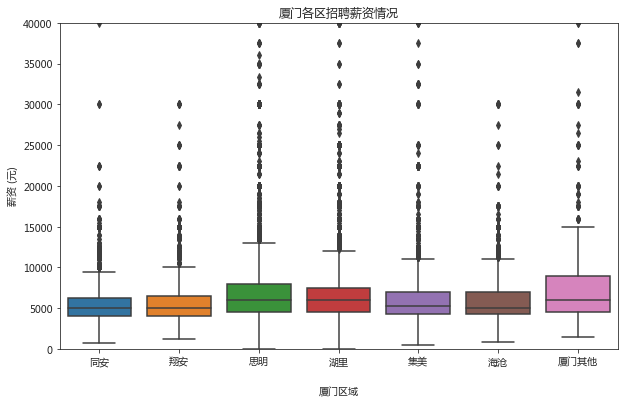

In [54]:
def draw_boxplot(data,x,y):
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax = sns.boxplot(x=x,y=y,data=data)
    ax.set(title='厦门各区招聘薪资情况',xlabel='\n' + '厦门区域',ylabel='薪资 (元)')
    ax.set_ylim([0,40000])
    
    fig.savefig('厦门各区招聘薪资情况.png')
    
draw_boxplot(jobs_xmrc_d,'城区','salary_A')

In [55]:
jobs_xmrc_dc = jobs_xmrc_d[['职位名称','salary_A','城区']]
jobs_xmrc_dcg = jobs_xmrc_dc.groupby(['salary_A','城区'],as_index=False).count()

In [56]:
jobs_xmrc_dcg.head()

,salary_A,城区,职位名称
0,1,思明,4
1,1,湖里,1
2,5,思明,3
3,6,思明,1
4,7,湖里,2


[Text(0,0.5,'数量'), Text(0.5,0,'薪资 （元/月）'), Text(0.5,1,'不同城区薪资分布')]

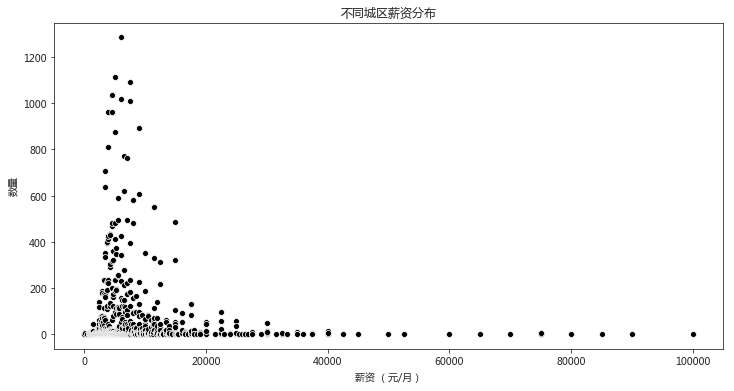

In [57]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = sns.scatterplot(x='salary_A',y='职位名称',data=jobs_xmrc_dcg,color='k')
ax.set(title='不同城区薪资分布',xlabel='薪资 （元/月）',ylabel='数量')
